In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [27]:
class UGMM(object):
    def __init__(self, X, K=2, sigma=2, mean_assignements=None, means=None):
        '''Initialize the UGMM object

        Parameters
        ----------
        X : _type_
            _description_
        K : int, optional
            _description_, by default 2
        sigma : int, optional
            _description_, by default 2
        mean_assignements : _type_, optional
            _description_, by default None
        means : _type_, optional
            _description_, by default None
        '''
        self.X = X
        self.K = K
        self.N = np.size(X)
        self.sigma2 = sigma**2
        self.mean_assignements = mean_assignements
        self.mu = means

    def init_params(self, seed=12345):
        '''_summary_

        Parameters
        ----------
        seed : int, optional
            _description_, by default 12345
        '''
        rng = default_rng(seed)
        self.m = rng.normal(loc=np.mean(self.X),
                            scale=np.std(self.X), size=(self.K))
        self.s2 = rng.uniform(size=self.K)
        self.phi = np.full((self.N, self.K), 1/self.K)

    def get_elbo(self):
        term1 = (self.K*0.5)*(1-np.log(2*np.pi*self.sigma2)) \
            - self.N*np.log(self.K * np.power(2*np.pi, 0.5))

        t2 = np.log(2*np.pi*self.s2)
        t2 -= (self.s2 + self.m**2) / self.sigma2
        t2 = t2.sum(axis=0) * 0.5

        t3 = -2*np.outer(self.X, self.m)
        t3 += self.X[:, np.newaxis]**2 + self.s2[np.newaxis, :] + \
            self.m[np.newaxis, :]**2 + 2*np.log(self.phi)
        t3 = np.multiply(t3, self.phi)
        t3 = np.sum(t3) * -0.5

        return term1 + t2 + t3

    def update_params(self):
        # Update phi
        t1 = np.multiply(self.m[np.newaxis, :], self.X[:, np.newaxis])
        t1 -= 0.5 * (self.s2 + self.m**2)
        self.phi = np.exp(t1)
        self.phi /= self.phi.sum(1)[:, np.newaxis]

        # Update m and s_sqr
        self.s2 = (1/self.sigma2 + self.phi.sum(axis=0))**-1
        numerator = np.multiply(
            self.phi, self.X.reshape(self.N, 1)).sum(axis=0)
        self.m = np.multiply(self.s2, numerator)

    def fit(self, max_iter=20, tol=1e-5):
        self.init_params()  # Initialize parameters
        self.prev_elbo = self.get_elbo()  # Calc ELBO

        for i in range(max_iter):
            self.update_params()  # Update parameters
            self.cur_elbo = self.get_elbo()  # Calc new ELBO

            # Print mean approximations
            if i % 5 == 0:
                print(f"{i} \tMeans{self.m} \tVar{self.s2}")

            # Check if ELBO convereged
            diff = np.abs(self.cur_elbo - self.prev_elbo)
            if diff < tol:
                print('ELBO converged with %.3f at iteration %d' %
                      (self.cur_elbo, i))
                return
            else:
                self.prev_elbo = self.cur_elbo
        print('ELBO ended with %.3f after %d iterations' %
              (self.cur_elbo, max_iter))

    def plot_classification(self):
        # Check that the classify method has run before
        assert(isinstance(self.approx_mean_assignements, np.ndarray))

        # Calc approx mean assignements for all data pts
        # Then sort data points according to their respective means
        joint_matrix = np.stack(
            (self.X, self.approx_mean_assignements), axis=1)
        sorted_matrix = np.sort(joint_matrix, axis=0)
        self.sorted_X = sorted_matrix[:, 0]
        self.sorted_approx_m = sorted_matrix[:, 1]

        # Calculate indices that separate data pts into diff clusters 
        # by approximate means and by actual means
        unique_approx_m, unique_approx_indices = np.unique(
            self.sorted_approx_m, return_index=True)
        unique_m, unique_actual_indices = np.unique(
            self.mean_assignements, return_index=True)

        assert(np.size(unique_approx_m) == np.size(unique_m))

        # Plot the graph
        fig, ax = plt.subplots(figsize=(15, 4))
        for i in range(np.size(unique_approx_m)-1):
            start_approx = unique_approx_indices[i]
            start_actual = unique_actual_indices[i]
            end_approx = unique_approx_indices[i+1]
            end_actual = unique_actual_indices[i+1]

            sns.distplot(self.X[start_actual:end_actual],
                         ax=ax, hist=False, kde=True)
            sns.distplot(
                self.sorted_X[start_approx:end_approx], hist=True, norm_hist=True)

        sns.distplot(self.X[unique_actual_indices[-1]:],
                     ax=ax, hist=False, kde=True)
        sns.distplot(
            self.sorted_X[unique_approx_indices[-1]:], hist=True, norm_hist=True)

    def classify(self, plot_classification=False):
        '''
        Computes num of data pts correctly classified as belonging to the correct kth Gaussian distribution
        and also calculates the percentage point increase over random guessing w/ probability 1/K.
        '''

        # Check for actual means and actual mean assignements
        assert(isinstance(self.mu, np.ndarray) and isinstance(
            self.mean_assignements, np.ndarray))

        # Calc Approx Mean Assignements
        self.approx_mean_assignements = self.m[np.argmax(self.phi, axis=1)]

        # Create dict that matches mean values to cluster number
        mu_sorted = np.sort(self.mu)
        mu_index = np.arange(np.size(self.mu))
        cluster_dict = dict(zip(mu_sorted, mu_index))

        # Create approx dict that matches approx mean values to cluster number
        m_sorted = np.sort(self.m)
        m_index = np.arange(np.size(self.m))
        approx_cluster_dict = dict(zip(m_sorted, m_index))

        # Plug mean and approx mean assignements into 
        # respective dictionaries to find cluster assignements
        cluster_assignements = np.zeros((self.N))
        approx_cluster_assignements = np.zeros((self.N))

        for i in range(self.N):
            cluster_assignements[i] = cluster_dict[self.mean_assignements[i]]
            approx_cluster_assignements[i] = approx_cluster_dict[self.approx_mean_assignements[i]]

        # Calc num of correct appox cluster assignements
        num_correct = np.count_nonzero(
            cluster_assignements == approx_cluster_assignements)
        percent_correct = num_correct/self.N

        # Num percentage points better than random guessing
        random_improvement = np.abs(percent_correct - 1/self.K) * 100

        print(f"\n{percent_correct}% of cluster assignements predicted correctly")
        print(
            f"{random_improvement:.2f} percentage points better than randomly guessing\n")

        if plot_classification:
            self.plot_classification()

    def generate_approx_data(self):
        '''
        Generates N samples of new data drawn from our approximate means, self.m, and
        our approximate standard deviations, self.s2
        '''

        # Repeat mean and variance approximations to enable code vectorization
        m_matrix = np.tile(self.m, self.N).reshape((self.N, self.m.size))
        s2_matrix = np.tile(self.s2, self.N).reshape((self.N, self.s2.size))

        # Draw N samples from our Gaussian mixture model
        self.c_matrix = np.zeros((self.N, self.K))
        c_index = np.random.randint(0, self.K, self.N)  # uniformly pick a model
        self.c_matrix[np.arange(self.N), c_index, ] = 1 # store model in 1-hot encoding
        self.c_mean = np.multiply(self.c_matrix, m_matrix).sum(axis=1)  # Find relevant mean
        self.c_s2 = np.ones((self.N))

        # Sort according to means while keeping their respective variances to help w/ plotting
        # Combine mean and variance vectors into matrix
        data_params = np.stack((self.c_mean, self.c_s2), axis=1)
        # find indicies that sort according to means w/ keeping their respective variances
        indices = data_params[:, 0].argsort()
        # rearrange mean variance pairs according to mean indicies
        data_params = data_params[indices]
        self.c_mean = data_params[:, 0]
        self.c_s2 = data_params[:, 1]

        # Draw from a Gaussian model w/ relevant mean and std dev of 1
        self.new_X = np.random.default_rng().normal(self.c_mean, self.c_s2)
        return self.new_X

    def plot_approx_data(self):
        '''
        Generate new data based on our approximate means and variances w/ N data points and K clusters. 
        Then plot it on the same graph as our original data.
        '''

        # PLOT ORIGINAL DATA -------------------------------------------------
        unique_val, unique_indices = np.unique(
            self.mean_assignements, return_index=True)  # Divide data pts by diff means

        fig, ax = plt.subplots(figsize=(15, 4))
        ax.set_title("Variational Inference on 3-Gaussian Mixture Model")
        for i in range(np.size(unique_indices) - 1):  # stop at 2nd to last value
            start = unique_indices[i]
            end = unique_indices[i+1]
            sns.distplot(self.X[start:end], ax=ax, rug=True)
        sns.distplot(self.X[unique_indices[-1]:], ax=ax, rug=True)

        # PLOT NEW APPROX DATA ------------------------------------------------
        self.generate_approx_data()  # Generate new approx data to then be able to plot it
        unique_val, unique_indices = np.unique(
            self.c_mean, return_index=True)  # Divide data pts by diff means

        for i in range(np.size(unique_indices) - 1):  # stop at 2nd to last value
            start = unique_indices[i]
            end = unique_indices[i+1]
            sns.distplot(self.new_X[start:end],
                         color='k', hist=False, kde=True)
        sns.distplot(self.new_X[unique_indices[-1]:],
                     color='k', hist=False, kde=True)
        plt.legend(["Gaussian 1", "Gaussian 2", "Gaussian 3",
                   "Variational Approximations"])

    def plot_approx_parameter(self):
        '''
        Plot our K approximate distributions, with means self.m and variances self.s2, 
        on the same graph as the original distributions, with means self.mu and variances of 1
        '''

        # Check that the actual means were passed into the object
        assert(isinstance(self.mu, np.ndarray))

        # Calculate where the data switches from one cluster to another.
        # B/c the means are sorted, when the means switch to a different value,
        # that's where our data starts being drawn from a new cluster
        unique_val, unique_indices, unique_counts = np.unique(self.mean_assignements,
                                                              return_index=True, return_counts=True)

        # Plot the graph
        fig, ax = plt.subplots(figsize=(15, 4))
        for i in range(np.size(unique_val) - 1):  # stop at 2nd to last value
            start = unique_indices[i]
            end = unique_indices[i+1]
            std_dev = np.sqrt(self.s2[i])
            sns.distplot(self.X[start:end], ax=ax, hist=True, norm_hist=True)
            sns.distplot(default_rng().normal(
                self.m[i], 1, unique_counts[i]), color='k', hist=False, kde=True)

        sns.distplot(self.X[unique_indices[-1]:],
                     ax=ax, hist=True, norm_hist=True)
        sns.distplot(np.random.normal(
            self.m[-1], 1, unique_counts[-1]), color='k', hist=False, kde=True)

In [22]:
class data_block(object):
    def __init__(self, K=2, sigma=2, N=100000):
        ''' Initialize data block object

        Parameters
        ----------
        K : int, optional
            number of Gaussians in mixture model, by default 2
        sigma : int, optional
            variance for distribution from which the
            k means are sampled, by default 2
        N : int, optional
            num data points to sample, by default 100000
        '''

        self.K = K
        self.sigma = sigma
        self.N = N

    def generate_data(self):
        ''' Generate data based on our mixture model

        Returns
        -------
        self.x : np.ndarray
           Data points from Gaussian mixture model
        '''

        # Draw K means from a Gaussian distribution
        self.mu = default_rng().normal(0, self.sigma, self.K)
        mu_matrix = np.tile(self.mu, self.N).reshape(
            (self.N, self.mu.size))  # create matrix of means

        # Draw N samples from our Gaussian mixture model
        self.c_matrix = np.zeros((self.N, self.K))
        c_index = np.random.randint(
            0, self.K, self.N)  # uniformly pick a model
        # store model info in one-hot encoding matrix
        self.c_matrix[np.arange(self.N), c_index, ] = 1
        self.c_mean = np.multiply(self.c_matrix, mu_matrix).sum(
            axis=1)  # Find mean for given models
        # sort means to make it easier to identify mean assignements when graphing
        self.c_mean = np.sort(self.c_mean)
        # Draw from a Gaussian model w/ relevant mean and std dev of 1
        self.X = default_rng().normal(self.c_mean, 1)

        return self.X

    def plot(self):
        unique_val, unique_indices = np.unique(self.c_mean, return_index=True)
        print("Means: ", unique_val)

        fig, ax = plt.subplots(figsize=(15, 4))
        for i in range(np.size(unique_indices) - 1):  # stop at 2nd to last value
            start = unique_indices[i]
            end = unique_indices[i+1]
            sns.distplot(self.X[start:end], ax=ax, rug=True)
        sns.distplot(self.X[unique_indices[-1]:], ax=ax, rug=True)

    def get_mean_assignements(self):
        return self.c_mean

    def get_means(self):
        return self.mu


In [23]:
data_block = data_block(K=3, sigma=3)

Means:  [-0.59732135  0.86738934  1.41174158]


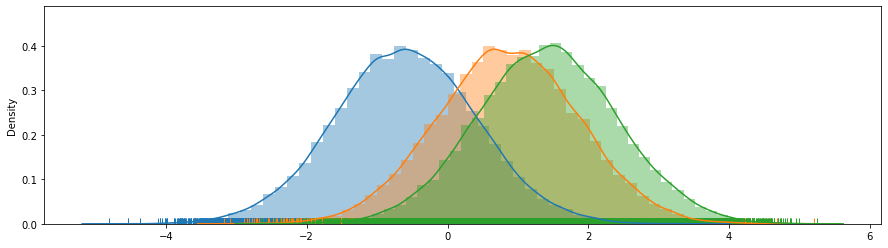

In [24]:
X = data_block.generate_data()
data_block.plot()
mean_assignements = data_block.get_mean_assignements()
mu = data_block.get_means()

In [25]:
UGMM = UGMM(X, K=3, sigma=3, mean_assignements=mean_assignements, means=mu)
UGMM.fit()
UGMM.classify()

0 	Means[-0.67495079  1.67620682 -0.02724659] 	Var[4.91352392e-05 2.38815038e-05 2.64725829e-05]
5 	Means[-0.47794897  1.58730797  0.49231517] 	Var[3.08000513e-05 2.90502858e-05 3.02025512e-05]
10 	Means[-0.55993985  1.52997553  0.66405981] 	Var[3.04461139e-05 2.96357441e-05 2.99290241e-05]
15 	Means[-0.58655725  1.48686759  0.7458634 ] 	Var[3.02728745e-05 2.98193740e-05 2.99112684e-05]
ELBO ended with -168808.822 after 20 iterations

0.58369% of cluster assignements predicted correctly
25.04 percentage points better than randomly guessing



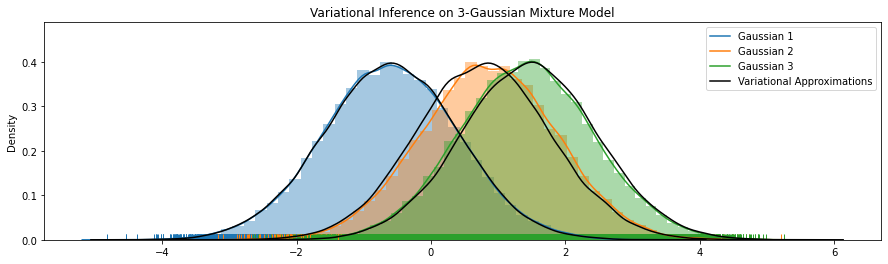

In [26]:
UGMM.plot_approx_data()